# Part 1: EDA of Login Information

In [32]:
import pandas as pd
import json
from datetime import datetime
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt

In [71]:
foldername = 'C:/DS/Springboard/ultimate_challenge/'
login_df = pd.read_json(foldername+'logins.json')
print(login_df.head())
print(login_df.tail())
print(login_df.info())

           login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21
               login_time
93137 1970-04-13 18:50:19
93138 1970-04-13 18:43:56
93139 1970-04-13 18:54:02
93140 1970-04-13 18:57:38
93141 1970-04-13 18:54:23
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB
None


15-min interval time series of login count

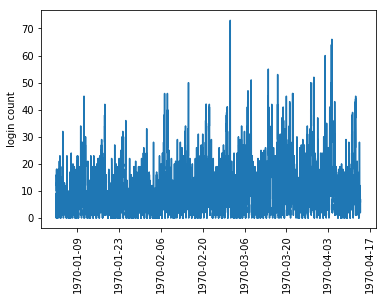

In [73]:
login_df = login_df.set_index(pd.DatetimeIndex(login_df['login_time']))
login_df_15 = login_df['login_time'].resample('15min').count()
plt.plot(login_df_15)
plt.xticks(rotation=90)
plt.ylabel('login count')
plt.show()

Peak login occurs at 1970-3-1 4:30

In [87]:
print(login_df_15[login_df_15==max(login_df_15)])

login_time
1970-03-01 04:30:00    73
Freq: 15T, Name: login_count, dtype: int64


Daily cycle: logins are high during non-business hours including evening to early morning and lunch break

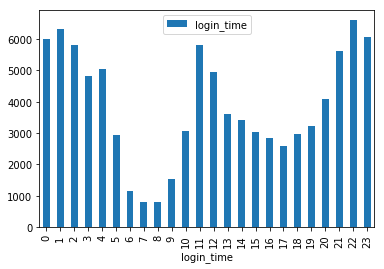

In [37]:
login_df.groupby(login_df.login_time.dt.hour).count().plot(kind="bar")
plt.show()

Day of week pattern: logins are higher on weekend than weekdays, increasing from Monday to Saturday

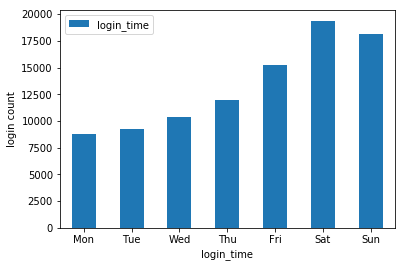

In [61]:
login_df.groupby(login_df.login_time.dt.dayofweek).count().plot(kind="bar")
days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
plt.ylabel('login count')
plt.xticks(range(7),('Mon','Tue','Wed','Thu','Fri','Sat','Sun'),rotation=0)
plt.show()

# Part 2 ‑ Experiment and metrics design  

Question 1. What    would     you     choose     as     the     key    measure    of     success    of     this    experiment     in  encouraging    driver     partners     to     serve    both     cities,    and    why    would     you     choose     this    metric?  

Answer: I would use toll costs to measure whether drivers serve both cities more frequently since drivers have to go through the bridge and pay the toll each time they travel to the other city. This metric is easy to measure and use.

Question 2: Describe    a    practical     experiment     you    would    design     to     compare     the    effectiveness    of     the  proposed     change     in     relation     to     the     key    measure    of     success.    Please    provide    details     on:     
a. how     you    will     implement     the    experiment    
b. what     statistical     test(s)     you    will     conduct     to     verify     the     significance    of     the  observation    
c. how     you    would     interpret     the     results    and    provide     recommendations     to     the     city  operations     team    along    with    any     caveats. 


Answer 2(a): Collect data on daily toll cost for 60 days or longer, which ensure the sample is indepedently and identically distributed. This is the sample of toll cost before implementing the expriment, say sample A. Collect data of daily toll cost for 60 days or longer after implementing the toll cost reimbursement policy, which is sample B representing the sample after change.  
Then construct a null hypothesis: the toll cost reimbursement policy does not increase the mean toll fee collected at the bridge. Alternative hypothesis: the toll cost reimbursement policy increases the mean toll fee collected at the bridge.

Answer 2(b): In this A/B test, I will use a Welch's t-test for hypothesis testing as the population standard deviation is unknown. To test the significance of the observation, a significance level of 0.05 is used, which means the probability of rejecting the null hypothesis while true is 0.05.   
There are four main steps for the Welch's t-test: 1) calculate t-score using the mean, variance and sample size of samples, 2) calculate degree of freedom using Welch-Satterthwaite equation, 3) based on the t-score and degree freedom, use t-table to find the closest probability value (p-value) , in this case, use one-tail t-table, 4) compare the p-value with significance level 0.05.  

Answer 2(c): , if p-value is smaller than 0.05, it means the probability of observing the same or more extreme mean difference is very small given the null hypothesis is true, therefore reject the null hypothesis and accept the alternative hypothesis, meaning the new policy promotes drivers serve both cities more frequently than before. Otherwise, the null hypothesis cannot be rejected, and there is no significant evidence to show the new policy works.   
One caveat of the test is the choice of significance level is subjective, and it affects the conclusion directly. Therefore it must be choosen beforehand and should be based on whether type I error (reject the null hypothesis while true) or type II error (accept the null hypothesis while false) brings greater damage. 

# Part 3 - Predictive modeling

In [125]:
with open(foldername+'ultimate_data_challenge.json') as f:
    for line in f:
        data = json.loads(line)
df = pd.DataFrame(data)
df.head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4
5,10.56,5.0,3.5,1.00,Winterfell,2014-06-06,iPhone,2014-01-09,0.0,2,True,100.0
6,3.95,4.0,NaN,1.00,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0
7,2.04,5.0,5.0,1.00,Winterfell,2014-01-29,iPhone,2014-01-28,0.0,2,False,100.0
8,4.36,5.0,4.5,1.00,Winterfell,2014-02-01,Android,2014-01-21,0.0,2,False,100.0
9,2.37,5.0,NaN,1.00,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0


In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Columns 'avg_rating_by_driver','avg_rating_of_driver' and 'phone' have null values. Need to fill the 'avg_rating_by_driver','avg_rating_of_driver' with average rating

In [127]:
df.fillna(df.mean(),inplace=True)
df.head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.700000,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.000000,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.300000,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.600000,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.400000,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4
5,10.56,5.0,3.500000,1.00,Winterfell,2014-06-06,iPhone,2014-01-09,0.0,2,True,100.0
6,3.95,4.0,4.601559,1.00,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0
7,2.04,5.0,5.000000,1.00,Winterfell,2014-01-29,iPhone,2014-01-28,0.0,2,False,100.0
8,4.36,5.0,4.500000,1.00,Winterfell,2014-02-01,Android,2014-01-21,0.0,2,False,100.0
9,2.37,5.0,4.601559,1.00,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0


In [140]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'],format="%Y/%m/%d", errors='coerce')
df['signup_date'] = pd.to_datetime(df['signup_date'],format="%Y/%m/%d", errors='coerce')

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [113]:
import seaborn as sns
color = sns.color_palette()

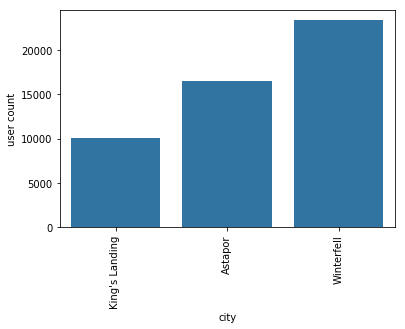

In [114]:
sns.countplot(x="city", data=df,color=color[0])
plt.xlabel('city')
plt.ylabel('user count')
plt.xticks(rotation='vertical')
plt.show()

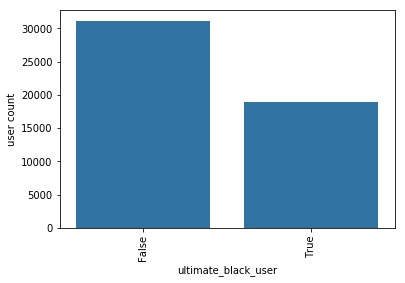

In [116]:
sns.countplot(x="ultimate_black_user", data=df,color=color[0])
plt.xlabel('ultimate_black_user')
plt.ylabel('user count')
plt.xticks(rotation='vertical')
plt.show()

In [162]:
len(df[df.ultimate_black_user==True])/len(df)

0.37708

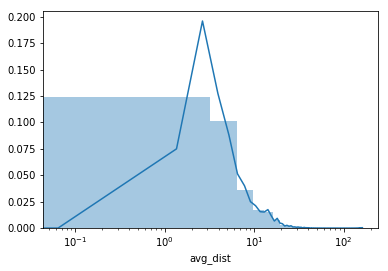

In [130]:
sns.distplot(df.avg_dist)
plt.xlabel('avg_dist')
plt.xscale('log')
plt.show()

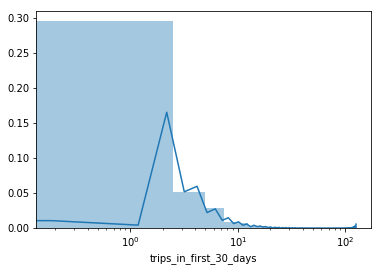

In [161]:
sns.distplot(df.trips_in_first_30_days)
plt.xlabel('trips_in_first_30_days')
plt.xscale('log')
plt.show()

In [167]:
len(df[df.trips_in_first_30_days <= 2])/len(df)

0.738

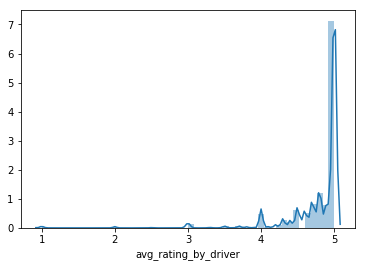

In [132]:
sns.distplot(df.avg_rating_by_driver)
plt.xlabel('avg_rating_by_driver')
plt.show()

In [164]:
len(df[df.avg_rating_by_driver> 4.5])/len(df)

0.83496

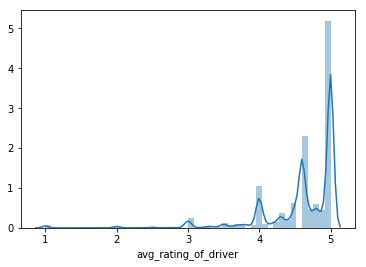

In [133]:
sns.distplot(df.avg_rating_of_driver)
plt.xlabel('avg_rating_of_driver')
plt.show()

In [165]:
len(df[df.avg_rating_of_driver> 4.5])/len(df)

0.72364

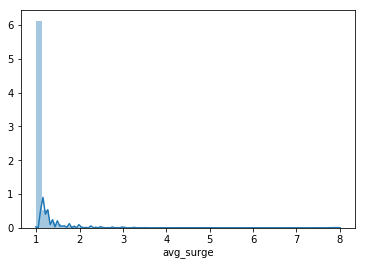

In [134]:
sns.distplot(df.avg_surge)
plt.xlabel('avg_surge')
plt.show()

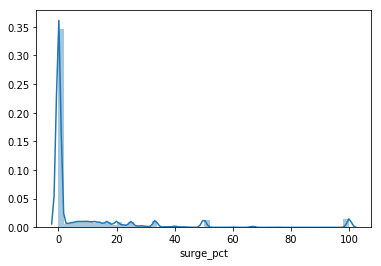

In [137]:
sns.distplot(df.surge_pct)
plt.xlabel('surge_pct')
plt.show()

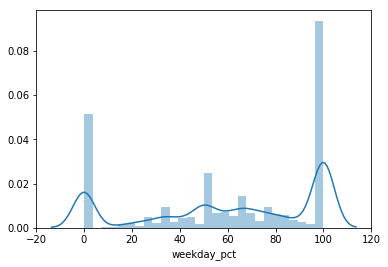

In [138]:
sns.distplot(df.weekday_pct)
plt.xlabel('weekday_pct')
plt.show()

In [166]:
print(len(df[df.weekday_pct==0])/len(df))
print(len(df[df.weekday_pct==100])/len(df))

0.18406
0.33318


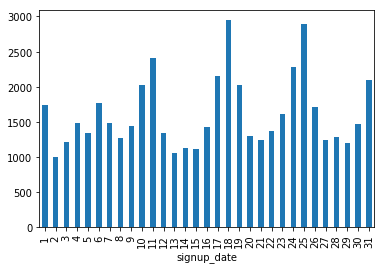

In [156]:
df.groupby(df.signup_date.dt.day)['avg_dist'].count().plot(kind="bar",color=color[0])
plt.show()

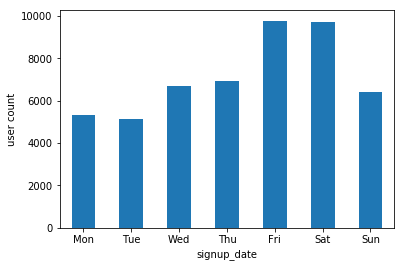

In [157]:
df.groupby(df.signup_date.dt.weekday)['avg_dist'].count().plot(kind="bar",color=color[0])
plt.ylabel('user count')
plt.xticks(range(7),('Mon','Tue','Wed','Thu','Fri','Sat','Sun'),rotation=0)
plt.show()

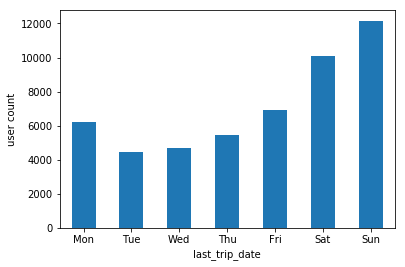

In [159]:
df.groupby(df.last_trip_date.dt.weekday)['avg_dist'].count().plot(kind="bar",color=color[0])
plt.ylabel('user count')
plt.xticks(range(7),('Mon','Tue','Wed','Thu','Fri','Sat','Sun'),rotation=0)
plt.show()

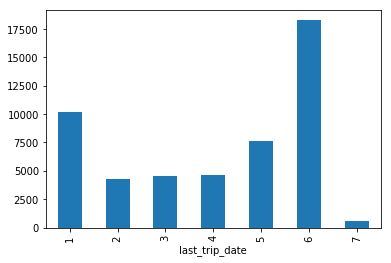

In [158]:
df.groupby(df.last_trip_date.dt.month)['avg_dist'].count().plot(kind="bar",color=color[0])
plt.show()

In [178]:
print(len(df[df.last_trip_date.dt.date >= max(df.last_trip_date.dt.date)-timedelta(days=30)])/len(df))

0.37608


In [179]:
df[df.last_trip_date.dt.date >= max(df.last_trip_date.dt.date)-timedelta(days=30)].describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000
mean,5.114788,4.762801,4.593679,1.073809,9.152797,3.306318,61.389034
std,4.615175,0.328175,0.518319,0.163170,15.588704,4.986743,29.487584
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.560000,4.700000,4.400000,1.000000,0.000000,0.000000,44.400000
50%,3.730000,4.800000,4.700000,1.000000,0.000000,2.000000,64.300000
75%,5.890000,5.000000,5.000000,1.090000,13.300000,4.000000,84.600000
max,160.960000,5.000000,5.000000,4.500000,100.000000,125.000000,100.000000


In [180]:
df[df.last_trip_date.dt.date < max(df.last_trip_date.dt.date)-timedelta(days=30)].describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000
mean,6.207939,4.787415,4.606309,1.075339,8.666739,1.658482,60.647032
std,6.238675,0.503312,0.591282,0.251361,22.179139,2.654222,40.982688
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.320000,4.800000,4.500000,1.000000,0.000000,0.000000,16.700000
50%,4.030000,5.000000,4.800000,1.000000,0.000000,1.000000,69.600000
75%,7.800000,5.000000,5.000000,1.000000,0.000000,2.000000,100.000000
max,129.890000,5.000000,5.000000,8.000000,100.000000,73.000000,100.000000


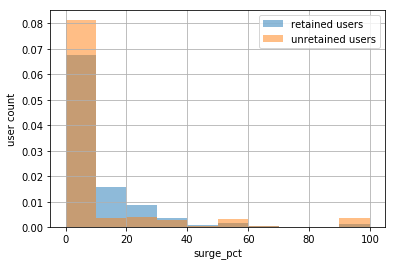

In [189]:
df[df.last_trip_date.dt.date >= max(df.last_trip_date.dt.date)-timedelta(days=30)].surge_pct.hist(bins=10,density=1,color=color[0],alpha=0.5)
df[df.last_trip_date.dt.date < max(df.last_trip_date.dt.date)-timedelta(days=30)].surge_pct.hist(bins=10,density=1,color=color[1],alpha=0.5)
plt.legend(('retained users','unretained users'))
plt.xlabel('surge_pct')
plt.ylabel('user count')
plt.show()

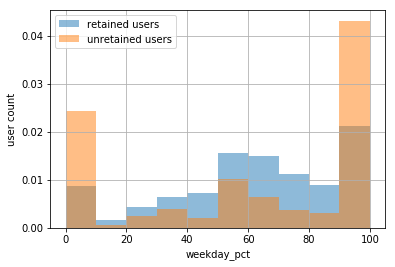

In [190]:
df[df.last_trip_date.dt.date >= max(df.last_trip_date.dt.date)-timedelta(days=30)].weekday_pct.hist(bins=10,density=1,color=color[0],alpha=0.5)
df[df.last_trip_date.dt.date < max(df.last_trip_date.dt.date)-timedelta(days=30)].weekday_pct.hist(bins=10,density=1,color=color[1],alpha=0.5)
plt.legend(('retained users','unretained users'))
plt.xlabel('weekday_pct')
plt.ylabel('user count')
plt.show()

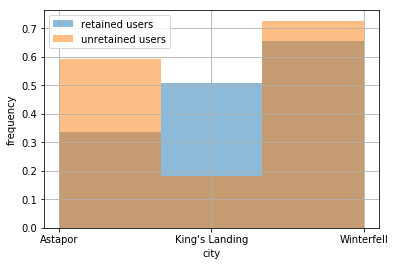

In [191]:
df[df.last_trip_date.dt.date >= max(df.last_trip_date.dt.date)-timedelta(days=30)].city.hist(bins=3,density=1,color=color[0],alpha=0.5)
df[df.last_trip_date.dt.date < max(df.last_trip_date.dt.date)-timedelta(days=30)].city.hist(bins=3,density=1,color=color[1],alpha=0.5)
plt.legend(('retained users','unretained users'))
plt.xlabel('city')
plt.ylabel('frequency')
plt.show()

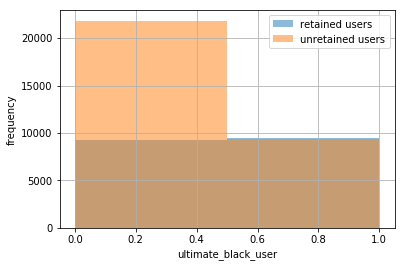

In [195]:
df[df.last_trip_date.dt.date >= max(df.last_trip_date.dt.date)-timedelta(days=30)].ultimate_black_user.hist(bins=2,color=color[0],alpha=0.5)
df[df.last_trip_date.dt.date < max(df.last_trip_date.dt.date)-timedelta(days=30)].ultimate_black_user.hist(bins=2,color=color[1],alpha=0.5)
plt.legend(('retained users','unretained users'))
plt.xlabel('ultimate_black_user')
plt.ylabel('frequency')
plt.show()

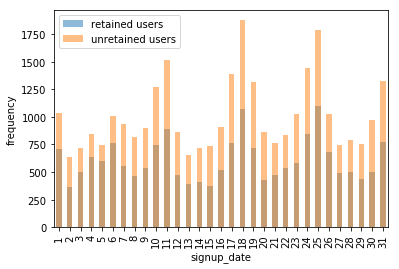

In [206]:
len_retained = len(df[df.last_trip_date.dt.date >= max(df.last_trip_date.dt.date)-timedelta(days=30)])
len_unretained = len(df[df.last_trip_date.dt.date < max(df.last_trip_date.dt.date)-timedelta(days=30)])
df[df.last_trip_date.dt.date >= max(df.last_trip_date.dt.date)-timedelta(days=30)]['city'].groupby(df.signup_date.dt.day).count().plot(kind="bar",color=color[0],alpha=0.5)
df[df.last_trip_date.dt.date < max(df.last_trip_date.dt.date)-timedelta(days=30)]['city'].groupby(df.signup_date.dt.day).count().plot(kind="bar",color=color[1],alpha=0.5)
plt.legend(('retained users','unretained users'))
plt.xlabel('signup_date')
#plt.xticks(range(7),('Mon','Tue','Wed','Thu','Fri','Sat','Sun'),rotation=0)
plt.ylabel('frequency')
plt.show()

In [213]:
print(len(df[(df.last_trip_date.dt.date >= max(df.last_trip_date.dt.date)-timedelta(days=30)) & (df.signup_date.dt.day < 7)])/len(df[df.signup_date.dt.day < 7]))
print(len(df[(df.last_trip_date.dt.date < max(df.last_trip_date.dt.date)-timedelta(days=30)) & (df.signup_date.dt.day < 7)])/len(df[df.signup_date.dt.day < 7]))

0.41673493270918666
0.5832650672908133


Based on data exploration, here are a summary of findings: 
- Winterfell has more users than King's Landing and Astapor. 
- ultimate_black_user acounts for about 38% of total users. 
- Most trips during the first 30 days after signup are < 10 miles per trip. 
- About 74% of the users take <= 2 trips during the first 30 days. 
- 83% of drivers give users rating higher than 4.5 while 72% of drivers get rating higher than 4.5. 
- Most trips do not happen during surge time. 
- 18% of the users never take trips on weekday, while 33% of the users only take trips on weekday.
- These users signed up during January of 2014 and most signups occured on Friday and Saturday
- 37.6% of the users took the last trip during the preceding 30 days
- Users who were active during the preceding 30 days took more trips during the first 30 days after signup on average compared to those who were not recently active
- Retained users have more spreadout surge_pct and weekday_pct than unretained users
- Users from King's Landing have higher probability to retain
- Most of unretained users are not ultimate_black_user
- 41.7% of users who signed up in the first 6 days were retained compared to the overall retain ratio of 37.6%

# Feature design and modeling

In [217]:
df['signup_first_6_days'] = 0
df.loc[df.signup_date.dt.day < 7,'signup_first_6_days'] = 1
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,signup_first_6_days
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,0
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,1
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


In [222]:
feature_list = ['surge_pct','signup_first_6_days','avg_surge','weekday_pct','city','avg_dist','avg_rating_of_driver','avg_rating_by_driver','trips_in_first_30_days','ultimate_black_user']
X = df[feature_list]
X = pd.get_dummies(X)
X.head()

,surge_pct,signup_first_6_days,avg_surge,weekday_pct,avg_dist,avg_rating_of_driver,avg_rating_by_driver,trips_in_first_30_days,ultimate_black_user,city_Astapor,city_King's Landing,city_Winterfell
0,15.4,0,1.10,46.2,3.67,4.7,5.0,4,True,0,1,0
1,0.0,0,1.00,50.0,8.26,5.0,5.0,0,False,1,0,0
2,0.0,1,1.00,100.0,0.77,4.3,5.0,3,False,1,0,0
3,20.0,0,1.14,80.0,2.36,4.6,4.9,9,True,0,1,0
4,11.8,0,1.19,82.4,3.13,4.4,4.9,14,False,0,0,1


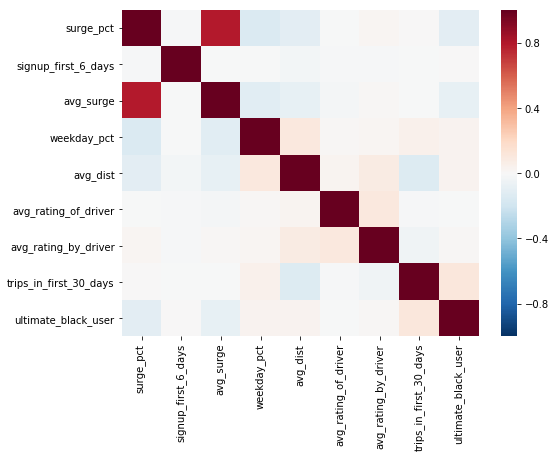

In [224]:
df_cor = df[feature_list].corr()
fig = plt.figure(figsize=(8,6))
sns.heatmap(df_cor,vmin=-1,vmax=1,cmap='RdBu_r')
plt.show()

In [225]:
# remove feature avg_surge since it correlates with surge_pct 
X.drop('avg_surge',axis=1,inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
surge_pct                 50000 non-null float64
signup_first_6_days       50000 non-null int64
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_rating_by_driver      50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
city_Astapor              50000 non-null uint8
city_King's Landing       50000 non-null uint8
city_Winterfell           50000 non-null uint8
dtypes: bool(1), float64(5), int64(2), uint8(3)
memory usage: 2.9 MB


In [231]:
df['active_in_June'] = 0
df.loc[df.last_trip_date.dt.month == 6,'active_in_June'] = 1
y = df['active_in_June']
y.mean()

0.36512

In [232]:
# train_test data split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=12)

In [227]:
# Logistic Regression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline

In [233]:
scaler = StandardScaler()
model = LogisticRegression(random_state=12)
pipeline = make_pipeline(scaler,model)

In [234]:
#model fit
pipeline.fit(X_train,y_train)
y_tr_pre = pipeline.predict(X_train)

print("accuracy score on train set is:",accuracy_score(y_train,y_tr_pre))
print("f1 score on train set is:",f1_score(y_train,y_tr_pre))
print("area under roc curve on train set is:",roc_auc_score(y_train,y_tr_pre))

accuracy score on train set is: 0.7000571428571428
f1 score on train set is: 0.4833152869376907
area under roc curve on train set is: 0.632956305280099


In [235]:
# predict on test set
y_ts_pre = pipeline.predict(X_test)
print("accuracy score on test set is:",accuracy_score(y_test,y_ts_pre))
print("f1 score on test set is:",f1_score(y_test,y_ts_pre))
print("area under roc curve on test set is:",roc_auc_score(y_test,y_ts_pre))

accuracy score on test set is: 0.7099333333333333
f1 score on test set is: 0.5024585477415666
area under roc curve on test set is: 0.6443337235426925


In [236]:
#random forest
#parameter tuning for random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

scaler = StandardScaler()
model = RandomForestClassifier()
steps = [('scaler',StandardScaler()),('model',RandomForestClassifier())]
pipeline = Pipeline(steps)
param_dict = {'model__n_estimators':[100,150],'model__max_depth':[5,10],'model__min_samples_leaf':[3,4],'model__max_features':[3,4,5],'model__random_state':[12]}

cv = GridSearchCV(pipeline,param_grid=param_dict,scoring='f1')

In [237]:
cv.fit(X_train,y_train)
print(cv.best_params_)
print(cv.best_score_)

{'model__max_depth': 10, 'model__max_features': 5, 'model__min_samples_leaf': 3, 'model__n_estimators': 150, 'model__random_state': 12}
0.6582836135912793


In [238]:
y_tr_pre = cv.predict(X_train)
y_ts_pre = cv.predict(X_test)
print("accuracy score on train set is:",accuracy_score(y_train,y_tr_pre))
print("f1 score on train set is:",f1_score(y_train,y_tr_pre))
print("area under roc curve on train set is:",roc_auc_score(y_train,y_tr_pre))
print("accuracy score on test set is:",accuracy_score(y_test,y_ts_pre))
print("f1 score on test set is:",f1_score(y_test,y_ts_pre))
print("area under roc curve on test set is:",roc_auc_score(y_test,y_ts_pre))

accuracy score on train set is: 0.7972571428571429
f1 score on train set is: 0.705291137137636
area under roc curve on train set is: 0.769041268629036
accuracy score on test set is: 0.7738
f1 score on test set is: 0.6726483357452968
area under roc curve on test set is: 0.7446286554039402


In [239]:
importances = cv.best_estimator_.named_steps["model"].feature_importances_
importances

array([0.18178786, 0.00788666, 0.15158047, 0.08375462, 0.03769129,
       0.22956001, 0.06475683, 0.0703623 , 0.02469978, 0.1269663 ,
       0.02095387])

Summary on model prediction:
- Since this question is to predict whether users will be active at the 6th month, it is a binary classification problem
- Select 11 features after removing correlated predicting variable and converting categorical variable to dummy variables: 'surge_pct','signup_first_6_days','weekday_pct','avg_dist','avg_rating_of_driver','avg_rating_by_driver','trips_in_first_30_days','ultimate_black_user', 'city_Astapor','city_King's Landing','city_Winterfell'
- Apply both logistic regression and random forest classifier to predict user retention
- Logistic regression predicts with decent model accuracy on test data of 0.71, f1 score of 0.5, auc_roc of 0.64
- Random forest predicts with better performance on test data: accuracy of 0.77, f1 score of 0.67, auc_roc of 0.74
- Feature 'avg_rating_by_driver' has the highest importance

# Insights and Recommendation

Data exploration and analysis in this study give insights on characters of users who are more likely to retain, such as King's Landing's users tend to retain compared to the other two cities. The prediction model also give decent hints on who are likely to retain. So the company can provide targeted promotion and initiatives to the likely-to-retain users in order to promote the long-term user retention rate.